#Libreries import

In [1]:
import pandas as pd
import numpy as np
import time
import concurrent.futures
import math
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

#Dataset import

In [2]:
!pip install -U -q PyDrive

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
drive.CreateFile({'id':'1fWSZsu_sn5N0SBsmEJX-CnDYAsAKRdbu'}).GetContentFile('dataset2_X_billboard_popularity_2.0.csv')
df = pd.read_csv("dataset2_X_billboard_popularity_2.0.csv").drop('Unnamed: 0',axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123212 entries, 0 to 123211
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           123212 non-null  float64
 1   year              123212 non-null  int64  
 2   acousticness      123212 non-null  float64
 3   artists           123212 non-null  object 
 4   danceability      123212 non-null  float64
 5   duration_ms       123212 non-null  float64
 6   energy            123212 non-null  float64
 7   explicit          123212 non-null  int64  
 8   id                123212 non-null  object 
 9   instrumentalness  123212 non-null  float64
 10  key               123212 non-null  float64
 11  liveness          123212 non-null  float64
 12  loudness          123212 non-null  float64
 13  mode              123212 non-null  float64
 14  name              123212 non-null  object 
 15  popularity        123212 non-null  float64
 16  release_date      12

#Hyperparameters tuning



1.   Month encoding
  *  cos,sin
  *  int
  *  categorical
2.   Target
  *  hit
  *  weeks
      *  int
          *  y^n con 0<n<1
          *  log(1+y)
      *  categorical
3.  New features
  *  sì
      *  intorno ? 
  *  no
4. Modello Machine Learning
5. Modello Deep Learning
6. Approccio
  * Past hits
  * Present hits
  * Future hits



##weeks encoding

y[1] - y[0] = 6.90875477931522
y[86] - y[1] = 4.453359423759798


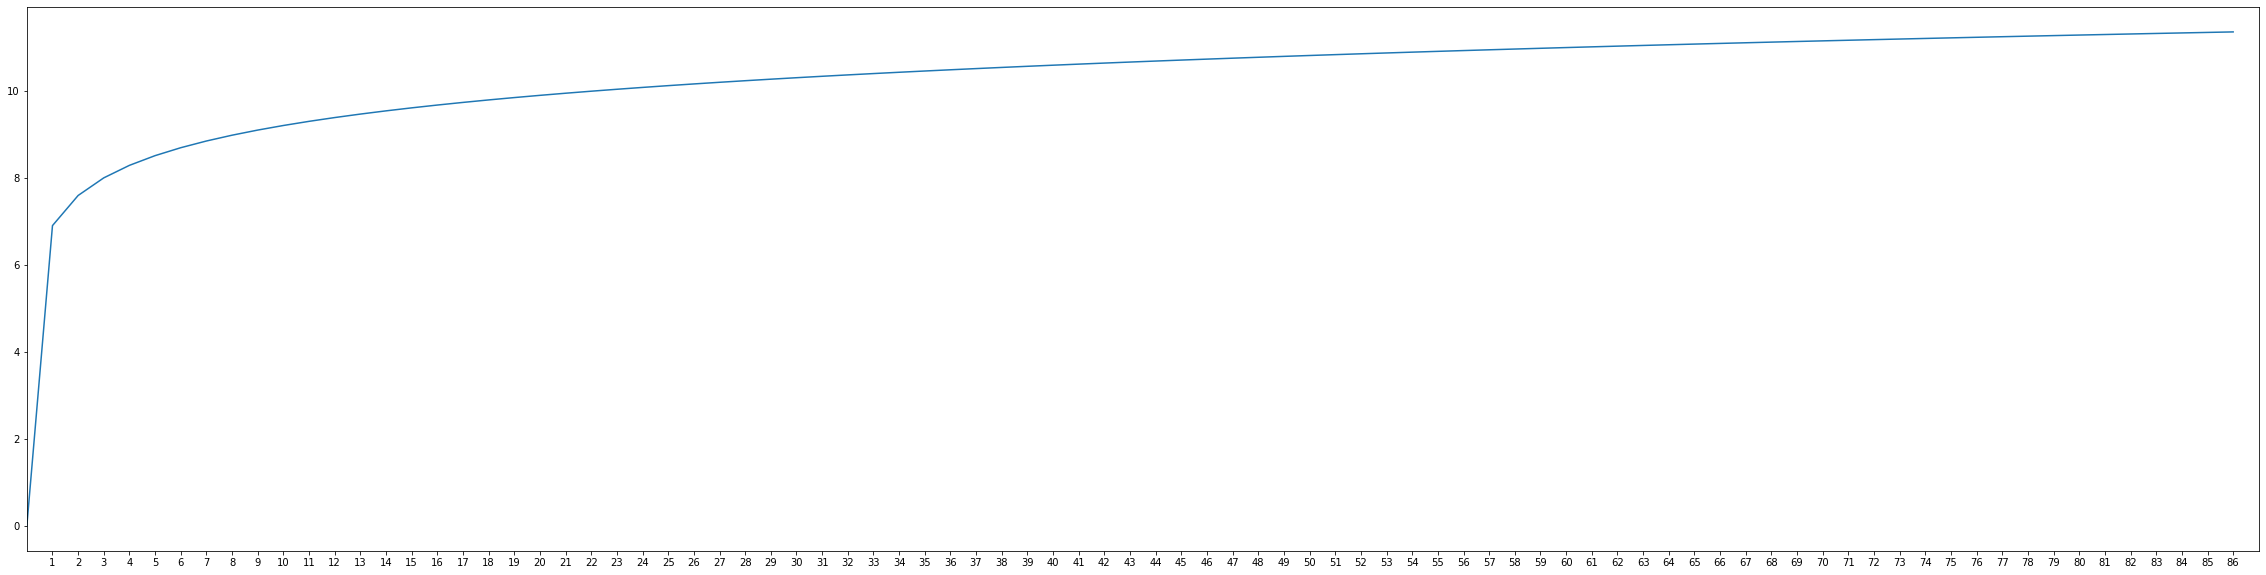

In [9]:
x = list(range(0,87))
y = []

y = [np.log(1+i*1000) for i in x]

plt.figure(figsize=(40,10))
plt.xticks(list(range(1,87)))
plt.xlim(0,87)
plt.plot(x,y)
print("y[1] - y[0] = " + str(y[1] - y[0]))
print("y[86] - y[1] = " + str(y[86] - y[1]))

##PARAMETERS

In [10]:
weeks_encoding_parameter = 1000
new_features_params = (1,0)    # (anni precedenti, anni successivi)
new_features_params_array = [(0,0), (1,0), (4,0), (9,0)]
linear_loudness = False # True

#Functions

In [11]:
def get_new_features(row,df_mean,audio_features,categorical_features):
  
  new_features = []
  new_categorical_features = []
  
  for x in audio_features:
    x_mean = df_mean[df_mean.year == row.year_YYYY][x].iloc[0]
    new_features.append(np.power((row[x] - x_mean),2))

  for w in categorical_features:
    w_mode = df_mean[df_mean.year == row.year_YYYY][w].iloc[0]
    if(w_mode == w):
      new_features.append(0)
    else:
      new_features.append(1)

  print("Completed for id:" + str(row.id) + ", year:" + str(row.year_YYYY))
  return new_features

In [12]:
def log_weeks(col,n):
  return np.log(1+col*n)

In [13]:
def get_season(date):
  year = str(date.year)
  seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
              'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
              'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
  if date in seasons['spring']:
      return 2 # spring
  if date in seasons['summer']:
      return 3 # summer
  if date in seasons['autumn']:
      return 4 # autumn
  else:
      return 1 # winter

#Pre-processing

In [14]:
# trasformo in int le colonne 'hit', 'weeks', 'key' e 'mode'

for x in ['hit', 'weeks', 'key', 'mode']:
  df[x] = df[x].apply(int)

In [15]:
df.id.count()

123212

In [16]:
df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,hit,weeks,past_pop_n_hit,past_pop_n_weeks
0,0.207,2020,0.9170,['Sam Smith'],0.758,220237.0,0.155,0,74Rr0afCO2T2v0Xmaq7Shz,0.000000,3,0.116,-10.252,1,Forgive Myself,5.0,2020-11-24,0.0447,122.026,0,0,17.0,336.0
1,0.302,2020,0.8050,['Sam Smith'],0.345,257651.0,0.340,0,0fGnjXBhmNfWGbL50VhkMd,0.000017,1,0.125,-9.337,1,Fix You - Live,4.0,2020-11-24,0.0342,136.219,0,0,17.0,336.0
2,0.497,2020,0.2470,"['DaBaby', 'Roddy Ricch']",0.746,181733.0,0.690,1,18cHFfnBjVpcQvy9eapiyU,0.000000,11,0.101,-7.956,1,ROCKSTAR,1.0,2020-11-23,0.1640,89.979,1,37,39.0,295.0
3,0.548,2020,0.2220,['Arijit Singh'],0.654,210620.0,0.713,0,6zgPxJ3HlrD8Vqv7OVLG0Y,0.000000,0,0.312,-7.566,1,"Nacchite Ye Panaina (From ""Dohchay"")",0.0,2020-11-23,0.0533,134.985,0,0,0.0,0.0
4,0.702,2020,0.0382,"['DaBaby', 'Meek Mill']",0.703,178949.0,0.555,1,3y3lDeOb2c3FYCniav00EY,0.000000,8,0.246,-8.199,1,8 Figures (feat. Meek Mill),63.0,2020-11-20,0.3820,177.205,0,0,59.0,230.0


**FEATURES CONTINUE**

Acustiche:
*  valence
*  acousticness
*  danceability
*  duration_ms --> normalizzare
*  energy
*  instrumentalness
*  liveness
*  loudness (--> convertire in lineare?) --> normalizzare
*  speechiness
*  tempo --> normalizzare

--> aggiungere new_feature per ognuna --> normalizzare


Temporali:
*  year --> normalizzare
*  month --> estrarre da 'release_date' --> codificare in cos,sin --> normalizzare
*  season --> estrarre da 'release_date' --> one-hot encoding


Bonus:
*  past_popularuty --> normalizzare
*  [popularity --> eliminare]

-- -- -- -- -- -- -- --



**FEATURES CATEGORICHE**

*  explicit --> one-hot encoding
*  key --> one-hot encoding
*  mode --> one-hot encoding

--> aggiungere new_feature per ognuna --> one-hot encoding



**TARGET**

*  hit
*  weeks --> codificare come log(1+y) oppure y^n con 0<n<1


In [17]:
audio_features = ['valence','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo']
categorical_features = ['explicit','key','mode']

In [18]:
# converto colonna 'release_date' in tipo datetime

df.release_date = pd.to_datetime(df.release_date,format="%Y-%m-%d",exact=False)

# creo feature 'month' --> estraggo da 'release_date'

month_array = df.release_date.apply(lambda x: x.month)
df.insert(2,'month', month_array)

# codifico 'month' come cos,sin

# 1) calcolo cos
df['cos(month)'] = np.cos(2 * math.pi * df['month'] / df['month'].max())

# 2) calcolo sin
df['sin(month)'] = np.sin(2 * math.pi * df['month'] / df['month'].max())

In [19]:
# creo la feature 'season'
season_array = df.release_date.apply(get_season)
df.insert(3,'season',season_array)

In [20]:
# trasformo 'loudness' da logaritmica a lineare
if (linear_loudness == True):
  df.loudness = 10**(df.loudness/10)

In [21]:
# elimino colonna 'popuparity'
df = df.drop('popularity',axis=1)

In [22]:
# NORMALIZZAZIONE

# creo copia della colonna 'year' da conservare non normalizzato
df['year_YYYY'] = df['year']

# creo copia della colonna 'month' da conservare non normalizzato
df['month_mm'] = df['month']

to_norm = ['year', 'month', 'duration_ms','loudness','tempo','cos(month)','sin(month)', 'past_pop_n_hit', 'past_pop_n_weeks']
df[to_norm] = (df[to_norm] - df[to_norm].min())/(df[to_norm].max()-df[to_norm].min())

In [23]:
df.head()

,valence,year,month,season,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,release_date,speechiness,tempo,hit,weeks,past_pop_n_hit,past_pop_n_weeks,cos(month),sin(month),year_YYYY,month_mm
0,0.207,0.983607,0.909091,4,0.9170,['Sam Smith'],0.758,0.038140,0.155,0,74Rr0afCO2T2v0Xmaq7Shz,0.000000,3,0.116,0.780434,1,Forgive Myself,2020-11-24,0.0447,0.501119,0,0,0.057823,0.081376,0.933013,0.25,2020,11
1,0.302,0.983607,0.909091,4,0.8050,['Sam Smith'],0.345,0.045083,0.340,0,0fGnjXBhmNfWGbL50VhkMd,0.000017,1,0.125,0.794789,1,Fix You - Live,2020-11-24,0.0342,0.559405,0,0,0.057823,0.081376,0.933013,0.25,2020,11
2,0.497,0.983607,0.909091,4,0.2470,"['DaBaby', 'Roddy Ricch']",0.746,0.030995,0.690,1,18cHFfnBjVpcQvy9eapiyU,0.000000,11,0.101,0.816453,1,ROCKSTAR,2020-11-23,0.1640,0.369513,1,37,0.132653,0.071446,0.933013,0.25,2020,11
3,0.548,0.983607,0.909091,4,0.2220,['Arijit Singh'],0.654,0.036355,0.713,0,6zgPxJ3HlrD8Vqv7OVLG0Y,0.000000,0,0.312,0.822572,1,"Nacchite Ye Panaina (From ""Dohchay"")",2020-11-23,0.0533,0.554337,0,0,0.000000,0.000000,0.933013,0.25,2020,11
4,0.702,0.983607,0.909091,4,0.0382,"['DaBaby', 'Meek Mill']",0.703,0.030478,0.555,1,3y3lDeOb2c3FYCniav00EY,0.000000,8,0.246,0.812641,1,8 Figures (feat. Meek Mill),2020-11-20,0.3820,0.727720,0,0,0.200680,0.055704,0.933013,0.25,2020,11


# NEW FEATURES

In [24]:
# creo un dataframe dove per ogni anno (=riga) memorizzo la media/moda delle features audio/categoriche calcolata sull'intorno di quell'anno (definito in base a new_features_params)

years = df.year_YYYY.unique()   # NB uso 'year_YYYY' (colonna anno non normalizzata)


for i, params in enumerate(new_features_params_array):

  mean_features = []

  for year in years:

    # calcolo anno inizio
    year_start = max(year - params[0], years.min())

    # calcolo anno fine
    year_end = min(year + params[1], years.max())

    # estraggo sub df --> intorno di anni in cui calcolare la media/moda
    mask_1 = df.year_YYYY <= year_end
    mask_2 = df.year_YYYY >= year_start
    sub_df = df[mask_1 & mask_2]
    
    mean_features_row = [year]

    # calcolo media delle features
    for x in audio_features:
      mean_features_row.append(sub_df[x].mean())

    for w in categorical_features:
      mean_features_row.append(sub_df[w].mode()[0])

    mean_features.append(mean_features_row)

  df_mean = pd.DataFrame(mean_features,columns=['year']+audio_features+categorical_features)

  new_features_list = ['valence_new_'+str(i),'acousticness_new_'+str(i),'danceability_new_'+str(i),'duration_ms_new_'+str(i),'energy_new_'+str(i),'instrumentalness_new_'+str(i),'liveness_new_'+str(i),'loudness_new_'+str(i),'speechiness_new_'+str(i),'tempo_new_'+str(i),'explicit_new_'+str(i),'key_new_'+str(i),'mode_new_'+str(i)]

  df[new_features_list] = df.apply(get_new_features, args=(df_mean,audio_features,categorical_features), result_type='expand', axis=1)

  # normalizzo new_features
  to_norm = ['valence_new_'+str(i),'acousticness_new_'+str(i),'danceability_new_'+str(i),'duration_ms_new_'+str(i),'energy_new_'+str(i),'instrumentalness_new_'+str(i),'liveness_new_'+str(i),'loudness_new_'+str(i),'speechiness_new_'+str(i),'tempo_new_'+str(i)]
  df[to_norm] = (df[to_norm] - df[to_norm].min())/(df[to_norm].max()-df[to_norm].min())

  # trasformo in int le colonne 'explicit_new',	'key_new',	'mode_new'
  for x in ['explicit_new_'+str(i), 'key_new_'+str(i), 'mode_new_'+str(i)]:
    df[x] = df[x].apply(int)

Output streaming troncato alle ultime 5000 righe.
Completed for id:3MvJztukgQFkiHFluA39Zh, year:1973
Completed for id:2V4mQWg6TJG7bSbqDzwM1B, year:2006
Completed for id:6ynVYMns3fP4uzPrhPijzA, year:2007
Completed for id:0RreVXhAVGCTTjppxFMFvb, year:1973
Completed for id:3tC8AwTtSolYgKZfEKPpy3, year:1991
Completed for id:5x9s06beVdFFyPNcaImH18, year:2011
Completed for id:4sTlOOWxFx5dR7SZmi7S79, year:2007
Completed for id:2k6hVKk4mERCEYscYWE6PO, year:2016
Completed for id:1KFTXJslA3vdcSxE4k8azK, year:1973
Completed for id:7bgtE0OW1SWdiBUCjCWKFR, year:1973
Completed for id:1zvUwUKsBKMoCu3UnW90xp, year:2008
Completed for id:4f2YqeGAggklftFrs5doVn, year:2017
Completed for id:0w3FFyoLff7Z39YhOxBz0J, year:1973
Completed for id:0FltFmk3k0U6R2vpzymmET, year:1995
Completed for id:0HZVk7vIBctBeHYvVEFeAL, year:1973
Completed for id:76qyLSDhKstj0KuOKkp3oB, year:2000
Completed for id:48obzdkQV1biEq8cPsGLys, year:2015
Completed for id:2bsGJGj9IiXXMlkaVV3U3b, year:1973
Completed for id:53snvwDtslvxOFN

In [25]:
df.head()

,valence,year,month,season,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,release_date,speechiness,tempo,hit,weeks,past_pop_n_hit,past_pop_n_weeks,cos(month),sin(month),year_YYYY,month_mm,valence_new_0,acousticness_new_0,danceability_new_0,duration_ms_new_0,energy_new_0,instrumentalness_new_0,liveness_new_0,loudness_new_0,speechiness_new_0,tempo_new_0,explicit_new_0,key_new_0,mode_new_0,valence_new_1,acousticness_new_1,danceability_new_1,duration_ms_new_1,energy_new_1,instrumentalness_new_1,liveness_new_1,loudness_new_1,speechiness_new_1,tempo_new_1,explicit_new_1,key_new_1,mode_new_1,valence_new_2,acousticness_new_2,danceability_new_2,duration_ms_new_2,energy_new_2,instrumentalness_new_2,liveness_new_2,loudness_new_2,speechiness_new_2,tempo_new_2,explicit_new_2,key_new_2,mode_new_2,valence_new_3,acousticness_new_3,danceability_new_3,duration_ms_new_3,energy_new_3,instrumentalness_new_3,liveness_new_3,loudness_new_3,speechiness_new_3,tempo_new_3,explicit_new_3,key_new_3,mode_new_3
0,0.207,0.983607,0.909091,4,0.9170,['Sam Smith'],0.758,0.038140,0.155,0,74Rr0afCO2T2v0Xmaq7Shz,0.000000,3,0.116,0.780434,1,Forgive Myself,2020-11-24,0.0447,0.501119,0,0,0.057823,0.081376,0.933013,0.25,2020,11,0.261879,0.756754,0.015625,0.000030,0.475522,0.000701,0.007359,0.003661,0.010460,0.000084,1,1,1,0.230196,0.718261,0.023557,0.000022,0.459413,0.002985,0.006806,0.002818,0.008365,0.000004,1,1,1,0.189145,0.695846,0.035623,7.939379e-06,0.454620,0.005264,0.007133,0.002335,0.006744,0.000144,1,1,1,0.199218,0.701956,0.062849,1.967404e-08,0.509126,0.007513,0.008539,0.002504,0.004098,0.000077,1,1,1
1,0.302,0.983607,0.909091,4,0.8050,['Sam Smith'],0.345,0.045083,0.340,0,0fGnjXBhmNfWGbL50VhkMd,0.000017,1,0.125,0.794789,1,Fix You - Live,2020-11-24,0.0342,0.559405,0,0,0.057823,0.081376,0.933013,0.25,2020,11,0.124093,0.523696,0.238106,0.000162,0.171905,0.000700,0.005583,0.001864,0.012970,0.011106,1,1,1,0.102616,0.491759,0.225623,0.000142,0.159867,0.002983,0.005089,0.001276,0.010614,0.013413,1,1,1,0.075680,0.473243,0.210635,1.011754e-04,0.155185,0.005262,0.005370,0.000953,0.008774,0.015556,1,1,1,0.081500,0.478283,0.185547,5.443971e-05,0.184531,0.007510,0.006594,0.001054,0.005713,0.014593,1,1,1
2,0.497,0.983607,0.909091,4,0.2470,"['DaBaby', 'Roddy Ricch']",0.746,0.030995,0.690,1,18cHFfnBjVpcQvy9eapiyU,0.000000,11,0.101,0.816453,1,ROCKSTAR,2020-11-23,0.1640,0.369513,1,37,0.132653,0.071446,0.933013,0.25,2020,11,0.000622,0.000025,0.011490,0.000004,0.011150,0.000701,0.010864,0.000289,0.000880,0.071743,1,1,1,0.000048,0.000749,0.018285,0.000008,0.015888,0.002985,0.010221,0.000090,0.001595,0.065206,1,1,1,0.002801,0.001657,0.028874,2.147552e-05,0.018605,0.005264,0.010627,0.000020,0.002410,0.058841,1,1,1,0.001998,0.001372,0.053314,5.341663e-05,0.011589,0.007513,0.012340,0.000035,0.004548,0.059579,1,1,1
3,0.548,0.983607,0.909091,4,0.2220,['Arijit Singh'],0.654,0.036355,0.713,0,6zgPxJ3HlrD8Vqv7OVLG0Y,0.000000,0,0.312,0.822572,1,"Nacchite Ye Panaina (From ""Dohchay"")",2020-11-23,0.0533,0.554337,0,0,0.000000,0.000000,0.933013,0.25,2020,11,0.003682,0.001414,0.000862,0.000013,0.019538,0.000701,0.024102,0.000093,0.008605,0.009106,1,1,1,0.008566,0.003602,0.000023,0.000008,0.025795,0.002985,0.025777,0.000004,0.006722,0.011217,1,1,1,0.019243,0.005380,0.000658,9.148295e-07,0.029327,0.005264,0.025278,0.000008,0.005280,0.013207,1,1,1,0.017174,0.004857,0.006256,2.959183e-06,0.020436,0.007513,0.023001,0.000002,0.002975,0.012336,1,1,1
4,0.702,0.983607,0.909091,4,0.0382,"['DaBaby', 'Meek Mill']",0.703,0.030478,0.555,1,3y3lDeOb2c3FYCniav00EY,0.000000,8,0.246,0.812641,1,8 Figures (feat. Meek Mill),2020-11-20,0.3820,0.727720,0,0,0.200680,0.055704,0.933013,0.25,2020,11,0.101884,0.077065,0.001881,0.000006,0.009036,0.000701,0.005488,0.000467,0.073312,0.190277,1,1,1,0.123223,0.090012,0.004870,0.000011,0.005897,0.002985,0.006195,0.000199,0.078422,0.197857,1,1,1,0.158225,0.098187,0.010504,2.675962e-05,0.004645,0.005264,0.005931,0

#Codifica 'weeks'

In [26]:
df['weeks_enc'] = df.weeks.apply(log_weeks,args=[weeks_encoding_parameter])

#Export (per analysis/visualisation)

In [27]:
# esporto dataset senza one hot encoding, da utilizzare per analysis/visualisation

from google.colab import  drive

# mounts the google drive to Colab Notebook
drive.mount('/content/drive',force_remount=True)

df.to_csv('/content/drive/My Drive/Colab Notebooks/datasets/dataset_final_4.0_no_ohe.csv')

Mounted at /content/drive


#One-Hot-Encoding

In [28]:
to_oh_encode = ['key', 'season']
df = pd.get_dummies(df,columns=to_oh_encode)

#Re-order

In [29]:
df.head()

,valence,year,month,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,liveness,loudness,mode,name,release_date,speechiness,tempo,hit,weeks,past_pop_n_hit,past_pop_n_weeks,cos(month),sin(month),year_YYYY,month_mm,valence_new_0,acousticness_new_0,danceability_new_0,duration_ms_new_0,energy_new_0,instrumentalness_new_0,liveness_new_0,loudness_new_0,speechiness_new_0,tempo_new_0,explicit_new_0,key_new_0,mode_new_0,valence_new_1,...,duration_ms_new_2,energy_new_2,instrumentalness_new_2,liveness_new_2,loudness_new_2,speechiness_new_2,tempo_new_2,explicit_new_2,key_new_2,mode_new_2,valence_new_3,acousticness_new_3,danceability_new_3,duration_ms_new_3,energy_new_3,instrumentalness_new_3,liveness_new_3,loudness_new_3,speechiness_new_3,tempo_new_3,explicit_new_3,key_new_3,mode_new_3,weeks_enc,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,season_1,season_2,season_3,season_4
0,0.207,0.983607,0.909091,0.9170,['Sam Smith'],0.758,0.038140,0.155,0,74Rr0afCO2T2v0Xmaq7Shz,0.000000,0.116,0.780434,1,Forgive Myself,2020-11-24,0.0447,0.501119,0,0,0.057823,0.081376,0.933013,0.25,2020,11,0.261879,0.756754,0.015625,0.000030,0.475522,0.000701,0.007359,0.003661,0.010460,0.000084,1,1,1,0.230196,...,7.939379e-06,0.454620,0.005264,0.007133,0.002335,0.006744,0.000144,1,1,1,0.199218,0.701956,0.062849,1.967404e-08,0.509126,0.007513,0.008539,0.002504,0.004098,0.000077,1,1,1,0.0000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0.302,0.983607,0.909091,0.8050,['Sam Smith'],0.345,0.045083,0.340,0,0fGnjXBhmNfWGbL50VhkMd,0.000017,0.125,0.794789,1,Fix You - Live,2020-11-24,0.0342,0.559405,0,0,0.057823,0.081376,0.933013,0.25,2020,11,0.124093,0.523696,0.238106,0.000162,0.171905,0.000700,0.005583,0.001864,0.012970,0.011106,1,1,1,0.102616,...,1.011754e-04,0.155185,0.005262,0.005370,0.000953,0.008774,0.015556,1,1,1,0.081500,0.478283,0.185547,5.443971e-05,0.184531,0.007510,0.006594,0.001054,0.005713,0.014593,1,1,1,0.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.497,0.983607,0.909091,0.2470,"['DaBaby', 'Roddy Ricch']",0.746,0.030995,0.690,1,18cHFfnBjVpcQvy9eapiyU,0.000000,0.101,0.816453,1,ROCKSTAR,2020-11-23,0.1640,0.369513,1,37,0.132653,0.071446,0.933013,0.25,2020,11,0.000622,0.000025,0.011490,0.000004,0.011150,0.000701,0.010864,0.000289,0.000880,0.071743,1,1,1,0.000048,...,2.147552e-05,0.018605,0.005264,0.010627,0.000020,0.002410,0.058841,1,1,1,0.001998,0.001372,0.053314,5.341663e-05,0.011589,0.007513,0.012340,0.000035,0.004548,0.059579,1,1,1,10.5187,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,0.548,0.983607,0.909091,0.2220,['Arijit Singh'],0.654,0.036355,0.713,0,6zgPxJ3HlrD8Vqv7OVLG0Y,0.000000,0.312,0.822572,1,"Nacchite Ye Panaina (From ""Dohchay"")",2020-11-23,0.0533,0.554337,0,0,0.000000,0.000000,0.933013,0.25,2020,11,0.003682,0.001414,0.000862,0.000013,0.019538,0.000701,0.024102,0.000093,0.008605,0.009106,1,1,1,0.008566,...,9.148295e-07,0.029327,0.005264,0.025278,0.000008,0.005280,0.013207,1,1,1,0.017174,0.004857,0.006256,2.959183e-06,0.020436,0.007513,0.023001,0.000002,0.002975,0.012336,1,1,1,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.702,0.983607,0.909091,0.0382,"['DaBaby', 'Meek Mill']",0.703,0.030478,0.555,1,3y3lDeOb2c3FYCniav00EY,0.000000,0.246,0.812641,1,8 Figures (feat. Meek Mill),2020-11-20,0.3820,0.727720,0,0,0.200680,0.055704,0.933013,0.25,2020,11,0.101884,0.077065,0.001881,0.000006,0.009036,0.000701,0.005488,0.000467,0.073312,0.190277,1,1,1,0.123223,...,2.675962e-05,0.004645,0.005264,0.005931,0.000084,0.083434,0.202757,1,1,1,0.153511,0.095911,0.025583,6.157944e-05,0.009913,0.007513,0.004827,0.000112,0.094652,0.197344,1,1,1,0.0000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [30]:
df_ordered = df[['id',
                'name', 
                'artists',
                'release_date',
                'year_YYYY',
                'month_mm',
                'month',
                'year',
                'cos(month)',
                'sin(month)',
                'valence',
                'acousticness',
                'danceability',
                'duration_ms',
                'energy',
                'instrumentalness',
                'liveness',
                'loudness',
                'speechiness',
                'tempo',
                'valence_new_0',
                'acousticness_new_0',
                'danceability_new_0',
                'duration_ms_new_0',
                'energy_new_0',
                'instrumentalness_new_0',
                'liveness_new_0',
                'loudness_new_0',
                'speechiness_new_0',
                'tempo_new_0',
                'valence_new_1',
                'acousticness_new_1',
                'danceability_new_1',
                'duration_ms_new_1',
                'energy_new_1',
                'instrumentalness_new_1',
                'liveness_new_1',
                'loudness_new_1',
                'speechiness_new_1',
                'tempo_new_1',
                'valence_new_2',
                'acousticness_new_2',
                'danceability_new_2',
                'duration_ms_new_2',
                'energy_new_2',
                'instrumentalness_new_2',
                'liveness_new_2',
                'loudness_new_2',
                'speechiness_new_2',
                'tempo_new_2',
                'valence_new_3',
                'acousticness_new_3',
                'danceability_new_3',
                'duration_ms_new_3',
                'energy_new_3',
                'instrumentalness_new_3',
                'liveness_new_3',
                'loudness_new_3',
                'speechiness_new_3',
                'tempo_new_3',
                'explicit',
                'key_0',
                'key_1',
                'key_2',
                'key_3',
                'key_4',
                'key_5',
                'key_6',
                'key_7',
                'key_8',
                'key_9',
                'key_10',
                'key_11',
                'mode',
                'explicit_new_0',
                'key_new_0',
                'mode_new_0',
                'explicit_new_1',
                'key_new_1',
                'mode_new_1',
                'explicit_new_2',
                'key_new_2',
                'mode_new_2',
                'explicit_new_3',
                'key_new_3',
                'mode_new_3',
                'season_1',
                'season_2',
                'season_3',
                'season_4',
                'hit',
                'weeks',
                'weeks_enc',
                'past_pop_n_hit',
                'past_pop_n_weeks']]

In [31]:
df_ordered.head()

,id,name,artists,release_date,year_YYYY,month_mm,month,year,cos(month),sin(month),valence,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence_new_0,acousticness_new_0,danceability_new_0,duration_ms_new_0,energy_new_0,instrumentalness_new_0,liveness_new_0,loudness_new_0,speechiness_new_0,tempo_new_0,valence_new_1,acousticness_new_1,danceability_new_1,duration_ms_new_1,energy_new_1,instrumentalness_new_1,liveness_new_1,loudness_new_1,speechiness_new_1,tempo_new_1,...,instrumentalness_new_3,liveness_new_3,loudness_new_3,speechiness_new_3,tempo_new_3,explicit,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode,explicit_new_0,key_new_0,mode_new_0,explicit_new_1,key_new_1,mode_new_1,explicit_new_2,key_new_2,mode_new_2,explicit_new_3,key_new_3,mode_new_3,season_1,season_2,season_3,season_4,hit,weeks,weeks_enc,past_pop_n_hit,past_pop_n_weeks
0,74Rr0afCO2T2v0Xmaq7Shz,Forgive Myself,['Sam Smith'],2020-11-24,2020,11,0.909091,0.983607,0.933013,0.25,0.207,0.9170,0.758,0.038140,0.155,0.000000,0.116,0.780434,0.0447,0.501119,0.261879,0.756754,0.015625,0.000030,0.475522,0.000701,0.007359,0.003661,0.010460,0.000084,0.230196,0.718261,0.023557,0.000022,0.459413,0.002985,0.006806,0.002818,0.008365,0.000004,...,0.007513,0.008539,0.002504,0.004098,0.000077,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0.0000,0.057823,0.081376
1,0fGnjXBhmNfWGbL50VhkMd,Fix You - Live,['Sam Smith'],2020-11-24,2020,11,0.909091,0.983607,0.933013,0.25,0.302,0.8050,0.345,0.045083,0.340,0.000017,0.125,0.794789,0.0342,0.559405,0.124093,0.523696,0.238106,0.000162,0.171905,0.000700,0.005583,0.001864,0.012970,0.011106,0.102616,0.491759,0.225623,0.000142,0.159867,0.002983,0.005089,0.001276,0.010614,0.013413,...,0.007510,0.006594,0.001054,0.005713,0.014593,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0.0000,0.057823,0.081376
2,18cHFfnBjVpcQvy9eapiyU,ROCKSTAR,"['DaBaby', 'Roddy Ricch']",2020-11-23,2020,11,0.909091,0.983607,0.933013,0.25,0.497,0.2470,0.746,0.030995,0.690,0.000000,0.101,0.816453,0.1640,0.369513,0.000622,0.000025,0.011490,0.000004,0.011150,0.000701,0.010864,0.000289,0.000880,0.071743,0.000048,0.000749,0.018285,0.000008,0.015888,0.002985,0.010221,0.000090,0.001595,0.065206,...,0.007513,0.012340,0.000035,0.004548,0.059579,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,37,10.5187,0.132653,0.071446
3,6zgPxJ3HlrD8Vqv7OVLG0Y,"Nacchite Ye Panaina (From ""Dohchay"")",['Arijit Singh'],2020-11-23,2020,11,0.909091,0.983607,0.933013,0.25,0.548,0.2220,0.654,0.036355,0.713,0.000000,0.312,0.822572,0.0533,0.554337,0.003682,0.001414,0.000862,0.000013,0.019538,0.000701,0.024102,0.000093,0.008605,0.009106,0.008566,0.003602,0.000023,0.000008,0.025795,0.002985,0.025777,0.000004,0.006722,0.011217,...,0.007513,0.023001,0.000002,0.002975,0.012336,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0.0000,0.000000,0.000000
4,3y3lDeOb2c3FYCniav00EY,8 Figures (feat. Meek Mill),"['DaBaby', 'Meek Mill']",2020-11-20,2020,11,0.909091,0.983607,0.933013,0.25,0.702,0.0382,0.703,0.030478,0.555,0.000000,0.246,0.812641,0.3820,0.727720,0.101884,0.077065,0.001881,0.000006,0.009036,0.000701,0.005488,0.000467,0.073312,0.190277,0.123223,0.090012,0.004870,0.000011,0.005897,0.002985,0.006195,0.000199,0.078422,0.197857,...,0.007513,0.004827,0.000112,0.094652,0.197344,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0.0000,0.200680,0.055704


#Export

In [32]:
df_ordered.to_csv('/content/drive/My Drive/Colab Notebooks/datasets/dataset_final_4.0.csv')